In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)

/Users/elenag/Desktop/PlotterLEE/PELEE3/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 11112020


In [5]:
SHRCALIBFACTOR = 1.00

In [6]:
# USING BDT?
USEBDT = True

In [7]:
# Doing Run3?
ISRUN3 = False

In [8]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [9]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [10]:
tree = "NeutrinoSelectionFilter"
NU  = 'neutrinoselection_filt_run1_overlay'   +ls.APPEND
NUE = 'neutrinoselection_filt_run1_overlay_intrinsic'   +ls.APPEND

mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
uproot_v = [mc,nue]
variables = ["true_e_visible","nu_pdg","ccnc","category","pi0_e","weightSpline","weightTune","weightSplineTimesTune","ppfx_cv", 'weightsFlux','weightsGenie','weightsReint','weightsPPFX']


#make the list unique
variables = list(set(variables))
print(variables)

nue  = nue.pandas.df(variables , flatten=False)
mc   = mc.pandas.df(variables , flatten=False)

['weightSpline', 'weightSplineTimesTune', 'weightsPPFX', 'weightsReint', 'ccnc', 'nu_pdg', 'weightsFlux', 'category', 'ppfx_cv', 'weightTune', 'pi0_e', 'weightsGenie', 'true_e_visible']


In [11]:
df_v = [mc,nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.    
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [12]:
df_v = [mc,nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    


In [13]:

scaleFlat = 2
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] =  (df['weightSplineTimesTune'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 

In [14]:
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

# Plotting part

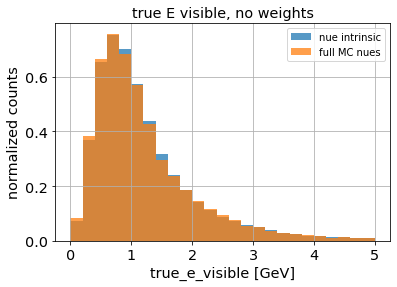

"\nnormMC  = mc['true_e_visible'].shape[0]\nnormNue = nue['true_e_visible'].shape[0]\nprint (normMC, normNue)\nynue,binEdges = np.histogram(nue['true_e_visible'] , density=False, bins=25, range=(0,5))\nymc ,binEdges = np.histogram(mc['true_e_visible']  , density=False, bins=25, range=(0,5))\nmenStdnue     = 10*np.sqrt(ynue)/normNue\nmenStdmc      = 10*np.sqrt(ymc)/normMC\n\n\nynue,binEdges = np.histogram(nue['true_e_visible'] , density=True, bins=25, range=(0,5))\nymc ,binEdges = np.histogram(mc['true_e_visible']  , density=True, bins=25, range=(0,5))\nprint (np.sqrt(ynue), menStdnue)\nbincenters = 0.5*(binEdges[1:]+binEdges[:-1])\nwidth      = (binEdges[1:]-binEdges[:-1])\nplt.bar(bincenters, ynue, width=width,  yerr=menStdnue,alpha=0.75, label='nue intrinsic')\nplt.bar(bincenters, ymc , width=width,  yerr=menStdmc,alpha=0.75, label='full MC nues')\nplt.show()\n"

In [76]:
import numpy as np
import matplotlib.pyplot as plt

nue  = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
mc   = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")

# the histogram of the data
n, bins, patches = plt.hist(nue['true_e_visible'], 25, density=True, range=(0,5), alpha=0.75, label='nue intrinsic')
n, bins, patches = plt.hist(mc['true_e_visible'] , 25, density=True, range=(0,5), alpha=0.75, label='full MC nues')

#n, bins, patches = plt.hist(nue['true_e_visible'], 25, density=True, weights = nue[ 'weightSplineTimesTuneTimesPPFX' ],range=(0,5), alpha=0.75, label='nue intrinsic')
#n, bins, patches = plt.hist(mc['true_e_visible'] , 25, density=True, weights =  mc[ 'weightSplineTimesTuneTimesPPFX' ],range=(0,5), alpha=0.75, label='full MC nues')


plt.xlabel('true_e_visible [GeV]')
plt.ylabel('normalized counts')
plt.title('true E visible, no weights')
plt.grid(True)
plt.legend()
plt.show()

'''
normMC  = mc['true_e_visible'].shape[0]
normNue = nue['true_e_visible'].shape[0]
print (normMC, normNue)
ynue,binEdges = np.histogram(nue['true_e_visible'] , density=False, bins=25, range=(0,5))
ymc ,binEdges = np.histogram(mc['true_e_visible']  , density=False, bins=25, range=(0,5))
menStdnue     = 10*np.sqrt(ynue)/normNue
menStdmc      = 10*np.sqrt(ymc)/normMC


ynue,binEdges = np.histogram(nue['true_e_visible'] , density=True, bins=25, range=(0,5))
ymc ,binEdges = np.histogram(mc['true_e_visible']  , density=True, bins=25, range=(0,5))
print (np.sqrt(ynue), menStdnue)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
width      = (binEdges[1:]-binEdges[:-1])
plt.bar(bincenters, ynue, width=width,  yerr=menStdnue,alpha=0.75, label='nue intrinsic')
plt.bar(bincenters, ymc , width=width,  yerr=menStdmc,alpha=0.75, label='full MC nues')
plt.show()
'''

In [ ]:
import plotter
import importlib
importlib.reload(plotter)

In [ ]:
nue  = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
data = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
mc   = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
ext  = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")

samples = {
    "mc" : mc, 
    "nue" : nue, 
    "data": data,
    "ext": mc
}

scaling = 0.5
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/2.18488e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
nueratio  = pot/1.85664e+22 #1.85664e+22 #norm on wiki: 1.85664e+22


weights = { #full sample mc = 0.38
            "mc"   : mcratio  * scaling,   
            "ext"  : mcratio  * scaling,
            "data" : nueratio * 0. ,  
            "nue"  : nueratio  ,  
}
print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

In [ ]:
QUERY = "(abs(nu_pdg) == 12 & ccnc == 0)"

import matplotlib.pyplot as plt
import matplotlib


VARIABLE, BINS, RANGE, XTIT = 'true_e_visible', 10, (0.15,2.15), "True Visible Energy [GeV]"


fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys= False, #True, #False,
    genieweight = "weightSplineTimesTuneTimesPPFX", #weightSplineTimesTuneTimesPPFX", #"noW", #"weightSplineTimesTuneTimesPPFX",
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

#print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
#print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

ax1.set_title('NuMI Run 1, Nue Comparisons',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinal/"+VARIABLE+"_S_Intrinsic_ReintFluxXsPPFX.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")